# 1. Cleaning

Note: the existing "2008.csv" file in the directory could be the smaller version of the original.
Consider downloading full-size file from http://stat-computing.org/dataexpo/2009/2008.csv.bz2

In [1]:
# import neccessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# show plot intermediately under the calling cell
%matplotlib inline

# disable some warnings
import warnings
warnings.simplefilter(action = "ignore")

# set to unlimited column display:
pd.set_option('display.max_columns', None)

# import database
df = pd.read_csv('2008.csv')

<center>Table: (sample) Dataframe including column dtype</center>

In [ ]:
dtypes = pd.Series(df.dtypes,name='dtypes')
df.head(2).append(dtypes)

## 1.1. Descriptive Statistics

<center>Figure: Correlation Matrix of some columns</center>

In [ ]:
def plot_corr_matr(df, figsize=(10, 8)):
    """
    Plot Correlation matrix using Seaborns heatmap

    Parameters
    ----------
    df: pandas.DataFrame

    figsize: tuple
        size of the whole plot
    """
    plt.figure(figsize=figsize)
    corr = df.corr().round(2)
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    sns.heatmap(
        corr,
        cmap="seismic",
        square=True,
        xticklabels=corr.columns.values,
        yticklabels=corr.columns.values,
        center=0,
        annot=True)
    plt.xticks(rotation=45)
    plt.show()
    
plot_corr_matr(df.loc[:,'DepTime':'Distance'])

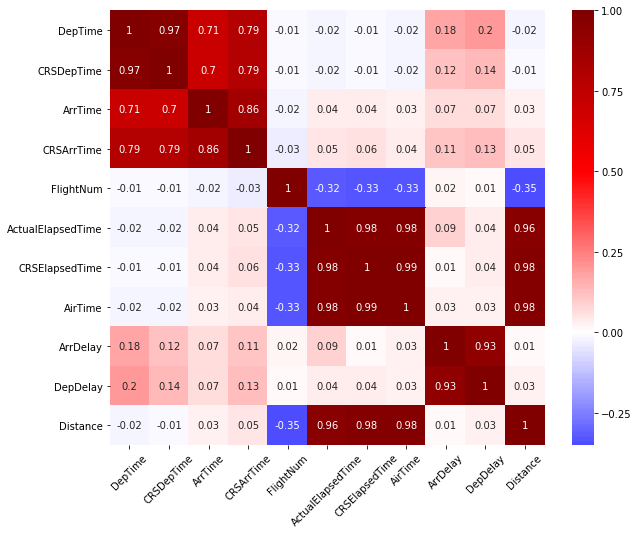

In [3]:
from dhp.plot.desc_stat import plot_corr_matr
plot_corr_matr(df.loc[:,'DepTime':'Distance'])

- To classify whether a flight is late or not, we choose __ArrTime as the label__.
- __ActualElapsedTime, CRSElapedTime, AirTime__ and __Distance__ have very high correlation (>0.95) so we can just keep one feature (Distance) as predictor.
- __CRSDepTime__ and __DepTime__ also has 0.97 correlation score, we just keep __DepTime__ as it is the real time data.
- __CRSArrTime__ and __ArrTime__ also has 0.87 correlation score, we just keep __ArrTime__ as it is the real time data.
- __ArrTime__, and __DepTime__ although have high correlation (0.72) but still not enough, we leave it to PCA to eliminate collinearity.

__IMPORTANT__: __DepDelay__ is a predictor and __ArrDelay__ is a lable; they have very high correlation (0.93), so if we just use DepDelay to predict ArrDelay, the result is likely to have a good score. But in this case, DepDelay just happens few hours before ArrDelay and will not give any significant practical value of prediction (We should be able to predict ArrDelay even days before the departure). So we want to see if other features can be a good predictors to ArrDelay, __delete DepDelay is the choice__.

In [2]:
# delete ActualElapsedTime, CRSElapedTime, AirTime columns
del df['ActualElapsedTime']
del df['CRSElapsedTime']
del df['AirTime']
del df['CRSDepTime']
del df['CRSArrTime']
del df['DepDelay']

- Our target is to predict __ArrDelay__, which is the sum of __Carrier delay, weather delay, NAS delay, security delay and late aircraft delay__ so those columns are also in the outcome side, can't be used to predict.

- __TaxiIn, TaxiOut, Cancelled, CancellationCode, Diverted__ are irrelevant features.
- We focus on Time more than date, so __Year, Month, DayofMonth__ and __DayofWeek__ should be deleted

In [3]:
# drop columns: Year:DayofWeek, TaxiIn:LateAircraftDelay
df = df.loc[:,'DepTime':'Distance']

<center>Table: Describe database</center>

In [4]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DepTime,6.87348e+06,NaN,NaN,NaN,1333.83,478.069,1,928,1325,1728,2400
ArrTime,6.85808e+06,NaN,NaN,NaN,1481.26,505.225,1,1107,1512,1909,2400
UniqueCarrier,7009728,20,WN,1201754,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FlightNum,7.00973e+06,NaN,NaN,NaN,2224.2,1961.72,1,622,1571,3518,9743
TailNum,6926363,5373,N476HA,4701,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrDelay,6.85503e+06,NaN,NaN,NaN,8.16845,38.5019,-519,-10,-2,12,2461
Origin,7009728,303,ATL,414513,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dest,7009728,304,ATL,414521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance,7.00973e+06,NaN,NaN,NaN,726.387,562.102,11,325,581,954,4962


## 1.2. NaN Cleaning

<center>Table: Recheck describe columns with NaN values</center>

In [4]:
from dhp.plot.desc_stat import desc_nan
desc_nan(df)

,Na Count,Na Percentage,mode,mean,std,min,25%,50%,75%,max
DepTime,136246,1.94367,555,1333.830046,478.068895,1.0,928.0,1325.0,1728.0,2400.0
ArrTime,151649,2.16341,1020,1481.258227,505.225129,1.0,1107.0,1512.0,1909.0,2400.0
TailNum,83365,1.18928,N476HA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrDelay,154699,2.20692,-5,8.168452,38.501937,-519.0,-10.0,-2.0,12.0,2461.0


__DepTime__ and __ArrTime__ are real collected statistic that directly effect the prediction of late arrival so any record has them as null, we drop that row:

In [5]:
# drop rows where DepTime or ArrTime is na
df.drop(df[df.DepTime.isna()].index, inplace = True)
df.drop(df[df.ArrTime.isna()].index, inplace = True)
df.drop(df[df.TailNum.isna()].index, inplace = True)
df.drop(df[df.ArrDelay.isna()].index, inplace = True)

<center>Figure: Distribution plot of all numeric columns</center>

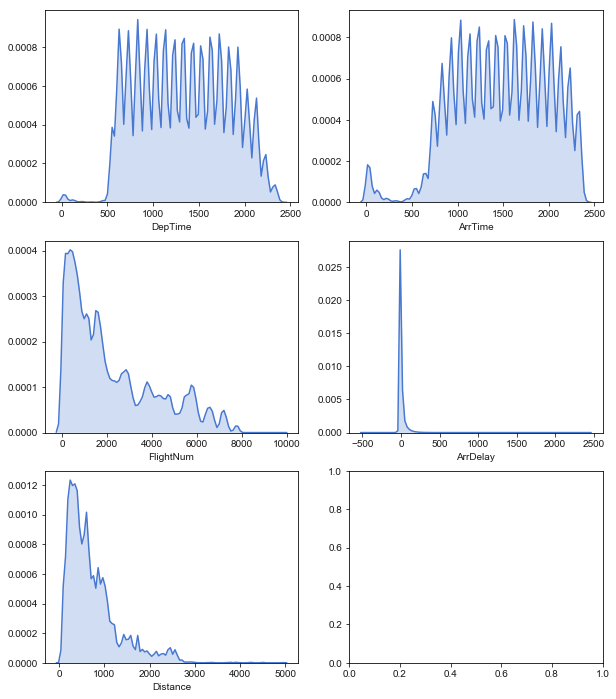

In [7]:
from dhp.plot.desc_stat import plot_features_dist
plot_features_dist(df)

We truncate some outliners that can be seen from the chart:
- FlightNum > 8000 (0.0006%)
- ArrDelay > 500 (0.22%)
- Distance > 3000 (0.15%)

In [6]:
df.drop(df[df.FlightNum>8000].index, axis = 0, inplace=True)
df.drop(df[df.ArrDelay>500].index, axis = 0, inplace=True)
df.drop(df[df.Distance>3000].index, axis = 0, inplace=True)

<center>Table: (sample) Database after cleaning</center>

In [10]:
df.head(2)

,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,Distance
0,2003.0,2211.0,WN,335,N712SW,-14.0,IAD,TPA,810
1,754.0,1002.0,WN,3231,N772SW,2.0,IAD,TPA,810


## 1.3. Feature Engineering

__DepTime, ArrTime__ are time values which if being stored in 10-based (decimal), their true values will be distorted (hours:minutes is not continuous on 10-based).
#=> convert to minute integer

In [7]:
# convert column to min:
def to_min(n):
    n = str(int(n))
    if len(n)<=2:
        return int(n)
    else:
        return int(n[:-2])*60+int(n[2:])
df.DepTime=df.DepTime.apply(to_min)
df.ArrTime=df.ArrTime.apply(to_min)

Convert all float dtype columns to int64 dtype

In [8]:
for col in df.columns:
    if df[col].dtype == np.float:
        df[col] = df[col].astype(np.int64)

<center>Table: (sample) Dataframe after dtype convertion</center>

In [13]:
dtypes = pd.Series(df.dtypes,name='dtypes')
df.head(2).append(dtypes)

,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,Distance
0,1203,1331,WN,335,N712SW,-14,IAD,TPA,810
1,424,602,WN,3231,N772SW,2,IAD,TPA,810
dtypes,int64,int64,object,int64,object,int64,object,object,int64


# 2. Data Transformation

## 2.1. One-hot-encoding

In order to pick which feature to use One-hot-encoding, we see how many unique data in each category data, then use boxplot to check the variation of ArrDelay by those features.
<br><br>
<center>Table: Unique value from each categorial feature</center>

In [14]:
pd.DataFrame(df.describe(include="O").loc['unique']).T

,UniqueCarrier,TailNum,Origin,Dest
unique,20,5362,303,302


<center>Figure: Boxplot of ArrDelay variance through 4 categorial features

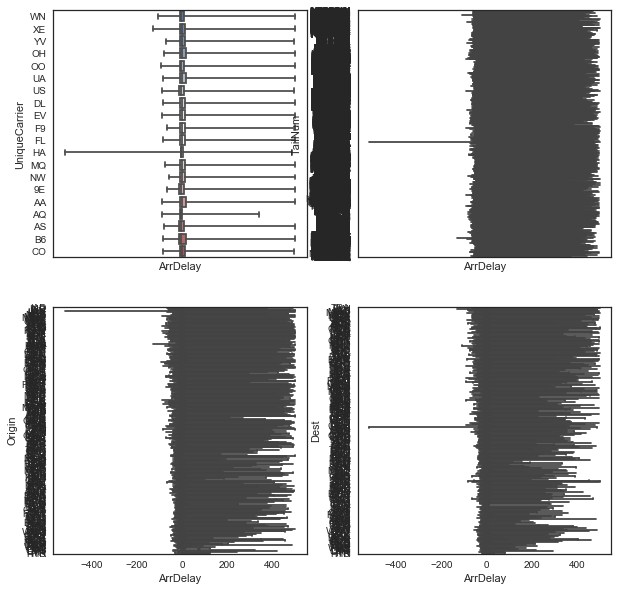

In [15]:
sns.set(style="white")
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,sharex=True, squeeze=True, 
                                figsize=(10,10))

sns.boxplot(x="ArrDelay", y="UniqueCarrier", data=df,
            whis=np.inf, palette="vlag",ax=ax1)

sns.boxplot(x="ArrDelay", y="TailNum", data=df,
            whis=np.inf, palette="vlag",ax=ax2)

sns.boxplot(x="ArrDelay", y="Origin", data=df,
            whis=np.inf, palette="vlag",ax=ax3)

sns.boxplot(x="ArrDelay", y="Dest", data=df,
            whis=np.inf, palette="vlag", ax=ax4)
plt.show()

We assume that each __TailNum__ belongs to 1 __UniqueCarrier__. How late a flight is seems to more dependent on __UniqueCarrier__ than the __TailNum__. But we need to check this hypothesis by showing if there is any __TailNum__ that is NOT operated by 1 __UniqueCarrier__.
<br><br>
<center>Table: TailNum that is not operated by one UniqueCarrie</center>

In [16]:
# Check if there is any TailNum that belongs to 2 UniqueCarriers
pd.DataFrame(df.groupby('TailNum').UniqueCarrier.unique()
                [df.groupby('TailNum').UniqueCarrier.unique()
                     .apply(lambda x: len(x)!=1)])

,UniqueCarrier
TailNum,
N376CA,"[OH, EV]"
N379CA,"[OH, EV]"


The table rejects our hypothesis, but it shows only 2 instances of __TailNum__.
The total number of records of N376CA and N379CA is 3171/6855024 (0.0462%) which is a very small affect (if any) on the prediction result. In addition, the amount of unique __TailNum__ is too large (5366) that might result in not having enough samples for each unique __TailNum__ (which makes the result more unreliable)

__Origin__ or __Dest__ can be reliable predictors but currently we skip these rows for computational benefits.

After finish analyzing those 4 categorial features, only 1 column to one-hot-encode is __UniqueCarrier__.

In [9]:
# one-hot-encode UniqueCarrier column
carrier = pd.get_dummies(df.UniqueCarrier)
carrier.reset_index(drop=True, inplace=True)

## 2.2. Normalize data

Because of feature scaling, new table of normalized data (in range [0,1]) is needed.

In [10]:
# delete categorical data:
for col in df.columns:
    if df[col].dtype == np.object:
        del df[col]

# Normalize the df
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(df)
X = pd.DataFrame(X, columns=df.columns)

In [11]:
# combine normalized data with one-hot-encoded columns
X = X.join(carrier)

In [12]:
# assign ArrDelay in format of boolean, True if ArrDelay > 30 minutes
Y = df.ArrDelay>30
Y.reset_index(drop=True, inplace=True)
del df['ArrDelay']

<center>Table: (sample) Predictor X (without PCA)

In [12]:
X[:2]

,DepTime,ArrTime,FlightNum,ArrDelay,Distance,9E,AA,AQ,AS,B6,CO,DL,EV,F9,FL,HA,MQ,NW,OH,OO,UA,US,WN,XE,YV
0,0.835302,0.924253,0.042667,0.495584,0.267851,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.293954,0.417651,0.412621,0.511286,0.267851,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## 2.3. PCA

<center>Figure: Explaination ratio though dimensions using PCA and Cumulative explained variance table in details</center>

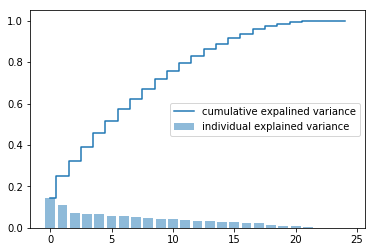

,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9,dim 10,dim 11,dim 12,dim 13,dim 14,dim 15,dim 16,dim 17,dim 18,dim 19,dim 20,dim 21,dim 22,dim 23,dim 24,dim 25
0,0.141586,0.24966,0.322052,0.390733,0.456134,0.514682,0.572537,0.62423,0.672122,0.716696,0.757787,0.793926,0.828843,0.861699,0.889374,0.916564,0.938245,0.95907,0.972592,0.98354,0.99231,0.997823,0.998936,1.0,1.0


In [13]:
from dhp.plot.desc_stat import plot_PCA
plot_PCA(X)

Using table and plot as above, I decide to keep 18 (over 24) dimensions which still explain 96% the dataset

In [14]:
from sklearn.decomposition import PCA
# create a PCA to reduce dimension to n
n = 18
pca = PCA(n_components=n)
# put data (predictor only) to pca and create pcadf
X = pd.DataFrame(pca.fit_transform(X))

To gain more speed on model tunning, we get 1,000,000 sample record from the full dataset:


In [15]:
# get random 100_000 samples records from full dataset to tune
x_tune = X.sample(n=100_000, random_state=25)
y_tune = Y.sample(n=100_000, random_state=25)

# get random 1_250_000 samples records from full dataset
# that differ from the x_100k and y_100k
x = (X[~X.index.isin(x_tune.index)]
        .sample(n=1_250_000, random_state=25))
y = (Y[~Y.index.isin(x_tune.index)]
        .sample(n=1_250_000, random_state=25))

In [16]:
# prepare the train and test data.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
                        x, y, test_size=0.2, random_state=25)

__Summary of prepared data__:

Tuning dataset (100k records):
- predictor: x_tune
- label: y_tune

training dataset (1m records):
- predictor: x_train
- label: y_train
    
Testing dataset (250k records):
- predictor: x_test
- label: y_test

y_tune, y_train, y_test are boolean, True = ArrDelay > 30 minutes

In [ ]:
# Save processed database to a csv file
import os
os.chdir(r'.\working_database')

x_tune.to_csv('x_tune.csv')
pd.DataFrame(y_tune).to_csv('y_tune.csv')
x_train.to_csv('x_train.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')
x_test.to_csv('x_test.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

os.chdir('..')

# 3. Classification Models

In [ ]:
# import neccessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# show plot intermediately under the calling cell
%matplotlib inline

# disable some warnings
import warnings
warnings.simplefilter(action = "ignore")

# set to unlimited column display:
pd.set_option('display.max_columns', None)

# Load processed database from a csv file
import os
os.chdir(r'.\working_database')

x_tune = pd.read_csv('x_tune.csv', index_col=0)
y_tune = pd.read_csv('y_tune.csv', index_col=0)
x_train = pd.read_csv('x_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
x_test = pd.read_csv('x_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

os.chdir('..')

The following model will use default parameters and sample classification report

## 3.1. Naive Bayes

Initialize the model and fit the train database

In [2]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train)

#Thử data k PCA, ko one hot encode

GaussianNB(priors=None)

In [3]:
from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=nb.predict(x_test)))

Classification_report: 
              precision    recall  f1-score   support

      False       0.87      0.96      0.91    217073
       True       0.18      0.06      0.09     32927

avg / total       0.78      0.84      0.80    250000



## 3.2. Logistics Regression

Initialize the model

In [17]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', # 'l1'
                        C = 1.0) # float

Tunning hyper-parameter using GridSearchCV

In [18]:
from sklearn.model_selection import GridSearchCV
# Defind the parameter values that should be searched
C_list = [0.1, 1, 10, 100, 1000]
penalty_list = ['l1','l2']
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(C=C_list,
                 penalty=penalty_list,
                 solver=solver_list)
# Instantiate the grid:
grid = GridSearchCV(lr, param_grid, cv=10, error_score=0.0,
                    scoring='f1_weighted', n_jobs=16)

# fit the grid with data
grid.fit(x_tune, y_tune)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(grid.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in grid.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

0.809818623890088
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


,rank_test_score,mean_fit_time,mean_test_score,param_C,param_penalty,param_solver
2,1,0.510012,0.809819,0.1,l1,liblinear
28,1,5.437571,0.809819,10,l2,sag
29,1,3.606199,0.809819,10,l2,saga
32,1,0.678045,0.809819,100,l1,liblinear
34,1,6.233811,0.809819,100,l1,saga
35,1,1.402529,0.809819,100,l2,newton-cg
36,1,0.470379,0.809819,100,l2,lbfgs
27,1,1.037133,0.809819,10,l2,liblinear
37,1,1.079467,0.809819,100,l2,liblinear
39,1,3.671451,0.809819,100,l2,saga


Use best parameters to fit x_train, get f1-weighted score of the best parameter using a test sample.

In [54]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.1,
                        penalty='l1',
                        solver='liblinear')
lr.fit(x_train, y_train)

from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=lr.predict(x_test)))

Classification_report: 
              precision    recall  f1-score   support

      False       0.87      1.00      0.93    217073
       True       0.00      0.00      0.00     32927

avg / total       0.75      0.87      0.81    250000



## 3.3. Decision Tree

Initialize the model

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='gini', # 'entropy'
                             min_samples_leaf=1, # float
                             class_weight=None # 'balance'
                             ) 
# tree.fit(x_train, y_train)

Tunning hyper-parameter using GridSearchCV

In [5]:
from sklearn.model_selection import GridSearchCV
# Defind the parameter values that should be searched
criterion_list = ['gini','entropy']
min_samples_leaf_list = [1,2,4,6,8,10]
class_weight_list = [None,'balanced']
# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(criterion=criterion_list,
                 min_samples_leaf=min_samples_leaf_list,
                 class_weight=class_weight_list)

# Instantiate the grid:
grid = GridSearchCV(tree, param_grid, cv=10, 
                    scoring='f1_weighted', n_jobs=16)

# fit the grid with data
grid.fit(x_tune, y_tune)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(grid.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in grid.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

0.8449740602277089
{'class_weight': None, 'criterion': 'entropy', 'min_samples_leaf': 2}


,rank_test_score,mean_fit_time,mean_test_score,param_criterion,param_min_samples_leaf,param_class_weight
7,1,18.374168,0.844974,entropy,2,None
6,2,18.956836,0.843327,entropy,1,None
1,3,10.557485,0.843320,gini,2,None
18,4,18.193923,0.842851,entropy,1,balanced
12,5,8.554075,0.842826,gini,1,balanced
2,6,10.175979,0.841526,gini,4,None
0,7,8.552073,0.841289,gini,1,None
8,8,17.572223,0.840886,entropy,4,None
3,9,9.744232,0.840871,gini,6,None
5,10,9.194690,0.840707,gini,10,None


Use best parameters to fit x_train, get f1-weighted score of the best parameter using a test sample.

In [6]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              min_samples_leaf=2,
                              class_weight=None)
                              
tree.fit(x_train, y_train)

from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=nb.predict(x_test)))

Classification_report: 
              precision    recall  f1-score   support

      False       0.87      0.96      0.91    217073
       True       0.18      0.06      0.09     32927

avg / total       0.78      0.84      0.80    250000



## 3.4. Random Forest

Initialize the model

In [2]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, #int
                           criterion = 'gini', #'entropy'
                           random_state=25) #int 
# rf.fit(x_train, y_train)

Tunning hyper-parameter using GridSearchCV

In [3]:
from sklearn.model_selection import GridSearchCV
# Defind the parameter values that should be searched
n_estimators_list = [10,5,50,100]
criterion_list = ['gini','entropy']
min_samples_leaf_list = [1,2,4,6,8,10]
class_weight_list = [None,'balanced']
random_state_list = [10, 25]
# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(n_estimators=n_estimators_list,
                  criterion=criterion_list,
                  min_samples_leaf=min_samples_leaf_list,
                  class_weight=class_weight_list,
                  random_state=random_state_list)

# Instantiate the grid:
grid = GridSearchCV(rf, param_grid, cv=10, error_score=0.0,
                    scoring='f1_weighted', n_jobs=16)

# fit the grid with data
grid.fit(x_tune, y_tune)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(grid.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in grid.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

0.8635352523553802
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_leaf': 4, 'n_estimators': 100, 'random_state': 25}


,rank_test_score,mean_fit_time,mean_test_score,param_class_weight,param_criterion,param_min_samples_leaf,param_n_estimators,param_random_state
167,1,239.740086,0.863535,balanced,entropy,4,100,25
166,2,241.816555,0.863219,balanced,entropy,4,100,10
156,3,124.793100,0.863033,balanced,entropy,2,50,10
118,4,119.804040,0.862987,balanced,gini,4,100,10
165,5,119.704510,0.862924,balanced,entropy,4,50,25
119,6,118.777315,0.862756,balanced,gini,4,100,25
158,7,246.908247,0.862538,balanced,entropy,2,100,10
164,8,121.353285,0.862439,balanced,entropy,4,50,10
110,9,122.862448,0.861863,balanced,gini,2,100,10
117,10,59.174660,0.861783,balanced,gini,4,50,25


Use best parameters to fit x_train, get f1-weighted score of the best parameter using a test sample.

In [4]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced',
                            criterion='entropy',
                            min_samples_leaf=4,
                            n_estimators=100,
                            random_state=10)                              
rf.fit(x_train, y_train)

from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=rf.predict(x_test)))

Classification_report: 
              precision    recall  f1-score   support

      False       0.95      0.98      0.97    217073
       True       0.84      0.66      0.74     32927

avg / total       0.94      0.94      0.94    250000



## 3.5. SVM

Initialize the model

In [2]:
from sklearn.svm import SVC
svm = SVC(C = 1.0,       # float
         kernel = 'rbf', # 'linear','poly', 'sigmoid'
         gamma = 'auto') # float
# svm.fit(x_train, y_train)

Tunning hyper-parameter using RandomizedSearchCV

In [15]:
from sklearn.model_selection import RandomizedSearchCV
# Defind the parameter values that should be searched
C_list = [1,10,100,1000]
kernel_list = ['rbf','linear','poly','sigmoid']
gamma_list = ['auto', 10, 0.2]
# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(C=C_list,
                  kernel=kernel_list,
                  gamma=gamma_list)

# Instantiate the rand:
rand = RandomizedSearchCV(svm, param_grid, cv=5, 
                         scoring='f1_weighted', n_jobs=16,
                         n_iter=5, random_state=25)

# fit the rand with data
rand.fit(x_tune, y_tune)

# examine the best model
print(rand.best_score_)
print(rand.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(rand.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in rand.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

0.9260195190844476
{'kernel': 'rbf', 'gamma': 10, 'C': 1000}


,rank_test_score,mean_fit_time,mean_test_score,param_kernel,param_gamma,param_C
2,1,7084.191863,0.926020,rbf,10,1000
1,2,364.100534,0.809819,poly,auto,10
3,2,13562.376055,0.809819,linear,0.2,100
4,2,5992.299981,0.809819,poly,0.2,1000
0,5,692.766594,0.774741,sigmoid,10,1000


Use best parameters to fit x_train, get f1-weighted score of the best parameter using a test sample.

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')               
svm.fit(x_train, y_train)

from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=svm.predict(x_test)))

# Z. Other

## Z.1. Pickle

In [ ]:
# Save a model into a pickle file.
import pickle
import os
os.chdir(r'.\saved_models')
pickle.dump(svm, open( "svm.model", "wb" ) )
os.chdir('..')

In [ ]:
# Load the model back from the pickle file.
import pickle
import os
os.chdir(r'.\saved_models')
lr = pickle.load(open("lr.model", "rb"))
nb = pickle.load(open("nb.model", "rb"))
rf = pickle.load(open("rf.model", "rb"))
tree = pickle.load(open("tree.model", "rb"))
svm = pickle.load(open("svm.model", "rb"))
os.chdir('..')

## Z.2. Learning Curve

In [ ]:
http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html


In [6]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=5, n_jobs=16)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=5, n_jobs=16)

plt.show()

Classification_report: 
              precision    recall  f1-score   support

      False       0.87      0.96      0.91    217073
       True       0.18      0.06      0.09     32927

avg / total       0.78      0.84      0.80    250000

